In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,OneHotEncoder
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 200)


# Load Data & Get First Insights

In [2]:
df = pd.read_csv("dataset/data.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
def show_summary_table(df:pd.DataFrame,show_as_display=False):
    summary = pd.DataFrame([{'col':col,
               'n_unique':df[col].nunique(),
               'col_type':df[col].dtype,
               'unique_values':df[col].unique(),
               'n_missing':df[col].isnull().sum()} 
              for col in df.columns])\
            .sort_values('n_unique',ascending=False)\
            .reset_index(drop=True)
    if show_as_display:
        display(summary)
    else:
        print(summary)

In [6]:
show_summary_table(df)

                 col  n_unique col_type                                      unique_values  n_missing
0         customerID      7043   object  [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...          0
1       TotalCharges      6531   object  [29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...          0
2     MonthlyCharges      1585  float64  [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...          0
3             tenure        73    int64  [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...          0
4      PaymentMethod         4   object  [Electronic check, Mailed check, Bank transfer...          0
5   DeviceProtection         3   object                     [No, Yes, No internet service]          0
6           Contract         3   object               [Month-to-month, One year, Two year]          0
7    StreamingMovies         3   object                     [No, Yes, No internet service]          0
8        StreamingTV         3   object                     [No, Yes, No internet 

- First look, there are no Nan or null values. Most of columns are discrete and only 3 column is continous values.
- TotalCharges column values should be float but column dtype is object. We need to cast to string.
- Some columns can be encoded as Binary like Churn [No,Yes : 0,1], Phone Service, PaperlesBilling etc. 
- Then visualize and analyze distribution of features and relation with Target(churn).

In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"],errors='coerce')

In [8]:
show_summary_table(df)

                 col  n_unique col_type                                      unique_values  n_missing
0         customerID      7043   object  [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...          0
1       TotalCharges      6530  float64  [29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...         11
2     MonthlyCharges      1585  float64  [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...          0
3             tenure        73    int64  [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...          0
4      PaymentMethod         4   object  [Electronic check, Mailed check, Bank transfer...          0
5   DeviceProtection         3   object                     [No, Yes, No internet service]          0
6           Contract         3   object               [Month-to-month, One year, Two year]          0
7    StreamingMovies         3   object                     [No, Yes, No internet service]          0
8        StreamingTV         3   object                     [No, Yes, No internet 

- There are 11 nan values in TotalCharges column. We will fill these values with mode. 

In [9]:
df.loc[df[df['TotalCharges'].isna()].index,'TotalCharges'] = df["TotalCharges"].mode().iloc[0]

In [10]:
show_summary_table(df)

                 col  n_unique col_type                                      unique_values  n_missing
0         customerID      7043   object  [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...          0
1       TotalCharges      6530  float64  [29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...          0
2     MonthlyCharges      1585  float64  [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...          0
3             tenure        73    int64  [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...          0
4      PaymentMethod         4   object  [Electronic check, Mailed check, Bank transfer...          0
5   DeviceProtection         3   object                     [No, Yes, No internet service]          0
6           Contract         3   object               [Month-to-month, One year, Two year]          0
7    StreamingMovies         3   object                     [No, Yes, No internet service]          0
8        StreamingTV         3   object                     [No, Yes, No internet 

In [11]:
def binary_encoder(df:pd.DataFrame) -> pd.DataFrame:
    temp_df = df.copy()
    binary_cols = [col for col in temp_df.columns if temp_df[col].dtype == 'O' and temp_df[col].nunique() == 2]
    for col in binary_cols:
        le = LabelEncoder()
        temp_df[col] = le.fit_transform(temp_df[col])
    return temp_df 

df_encoded = binary_encoder(df)

In [12]:
show_summary_table(df_encoded)

                 col  n_unique col_type                                      unique_values  n_missing
0         customerID      7043   object  [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...          0
1       TotalCharges      6530  float64  [29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...          0
2     MonthlyCharges      1585  float64  [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...          0
3             tenure        73    int64  [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...          0
4      PaymentMethod         4   object  [Electronic check, Mailed check, Bank transfer...          0
5   DeviceProtection         3   object                     [No, Yes, No internet service]          0
6           Contract         3   object               [Month-to-month, One year, Two year]          0
7    StreamingMovies         3   object                     [No, Yes, No internet service]          0
8        StreamingTV         3   object                     [No, Yes, No internet 

In [13]:
def show_feature_summary(df:pd.DataFrame,col:str,target:str):
    print(f"------------ Summary :: {col} -------------\n")
    summary = pd.concat([df[col].value_counts(ascending=True),
                         df[col].value_counts(normalize=True,ascending=True),
                          df.groupby(col)[target].mean()],
                         keys=['n_observation','observation_ratio','target_mean'],
                         names=['Columns'],
                         axis=1)
    print(summary,end="\n\n\n")
    
## Let's examine categorical columns or possible categorical columns like gender, PhoneService etc. They are also categorical because this columns are only 2 values. 

In [14]:
summary_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() < 10]
for col in summary_cols:
    show_feature_summary(df=df_encoded,col=col,target='Churn')

------------ Summary :: gender -------------

Columns  n_observation  observation_ratio  target_mean
gender                                                
0                 3488              0.495        0.269
1                 3555              0.505        0.262


------------ Summary :: SeniorCitizen -------------

Columns        n_observation  observation_ratio  target_mean
SeniorCitizen                                               
1                       1142              0.162        0.417
0                       5901              0.838        0.236


------------ Summary :: Partner -------------

Columns  n_observation  observation_ratio  target_mean
Partner                                               
1                 3402              0.483        0.197
0                 3641              0.517        0.330


------------ Summary :: Dependents -------------

Columns     n_observation  observation_ratio  target_mean
Dependents                                              

There are not too rare values(observation_ratio) in columns. So just keep going on to analysis..

In [15]:
outlier_cols = [col for col in df_encoded.columns 
                if df_encoded[col].dtype in ['int','float'] 
                and df_encoded[col].nunique() > 10 ]
outlier_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [16]:
def calculate_iqr_boundaries(df:pd.DataFrame,col:str,q1_ratio:float,q3_ratio:float) -> tuple:
    q1 = df[col].quantile(q1_ratio)
    q3 = df[col].quantile(q3_ratio)
    iqr = q3-q1
    low_limit = q1 - (1.5 * iqr)
    up_limit = q3 + (1.5 * iqr)
    return low_limit,up_limit

def check_outliers(df:pd.DataFrame,col:str,q1_ratio:float,q3_ratio:float) -> bool:
    low_limit, up_limit = calculate_iqr_boundaries(df,col,q1_ratio,q3_ratio)
    df_outlier = df[(df[col] < low_limit) | (df[col] > up_limit)]
    return df_outlier.any(axis=None)


In [17]:
for col in outlier_cols:
    is_outlier_exist = check_outliers(df_encoded,col,q1_ratio=.25,q3_ratio=.75)
    print(col," is outlier exist:",is_outlier_exist)

tenure  is outlier exist: False
MonthlyCharges  is outlier exist: False
TotalCharges  is outlier exist: False


There are no outliers in numerical columns. So just keep going. If they are, we could fill these outliers with imputer, mean, median, boundaries or just drop them. 

In [18]:
def one_hot_encoder(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df_temp = df.copy()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe.fit(df_temp[cols])
    
    df_ohe = pd.DataFrame(ohe.transform(df_temp[cols]),columns=ohe.get_feature_names_out())
    df_final = pd.concat([df, df_ohe], axis=1).drop(columns=ohe.feature_names_in_,axis=1)

    return df_final


In [19]:
ohe_cols = [col for col in df_encoded 
            if df_encoded[col].dtype == 'O'
            and df_encoded[col].nunique() < 10]
ohe_cols 

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [20]:
show_summary_table(df[ohe_cols])

                col  n_unique col_type                                      unique_values  n_missing
0     PaymentMethod         4   object  [Electronic check, Mailed check, Bank transfer...          0
1     MultipleLines         3   object                        [No phone service, No, Yes]          0
2   InternetService         3   object                             [DSL, Fiber optic, No]          0
3    OnlineSecurity         3   object                     [No, Yes, No internet service]          0
4      OnlineBackup         3   object                     [Yes, No, No internet service]          0
5  DeviceProtection         3   object                     [No, Yes, No internet service]          0
6       TechSupport         3   object                     [No, Yes, No internet service]          0
7       StreamingTV         3   object                     [No, Yes, No internet service]          0
8   StreamingMovies         3   object                     [No, Yes, No internet service]  

In [21]:
df2 = one_hot_encoder(df=df_encoded,cols=ohe_cols)

In [22]:
show_summary_table(df2,show_as_display=True)

,col,n_unique,col_type,unique_values,n_missing
0,customerID,7043,object,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",0
1,TotalCharges,6530,float64,"[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...",0
2,MonthlyCharges,1585,float64,"[29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...",0
3,tenure,73,int64,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",0
4,PaymentMethod_Credit card (automatic),2,float64,"[0.0, 1.0]",0
5,Contract_Two year,2,float64,"[0.0, 1.0]",0
6,Contract_One year,2,float64,"[0.0, 1.0]",0
7,StreamingMovies_Yes,2,float64,"[0.0, 1.0]",0
8,OnlineBackup_Yes,2,float64,"[1.0, 0.0]",0
9,PaymentMethod_Electronic check,2,float64,"[1.0, 0.0]",0


In [23]:

X = df2.drop(columns=['customerID','Churn'])
y = df2[["Churn"]]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=74)

In [24]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [25]:

model_rf = RandomForestClassifier(random_state=67)
model_rf.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=67)

In [26]:
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [27]:
y_pred = model_rf.predict(X_test_scaled)

In [28]:
display(pd.DataFrame.from_dict(classification_report(y_true=y_test,y_pred=y_pred,output_dict=True)))
print("Auc Score:",roc_auc_score(y_test,y_pred))

,0,1,accuracy,macro avg,weighted avg
precision,0.821,0.621,0.782,0.721,0.768
recall,0.901,0.453,0.782,0.677,0.782
f1-score,0.859,0.524,0.782,0.691,0.770
support,1036.000,373.000,0.782,1409.000,1409.000


Auc Score: 0.6768311302493608


In [29]:
def plot_importance(model, features):
    num = len(features.columns)
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

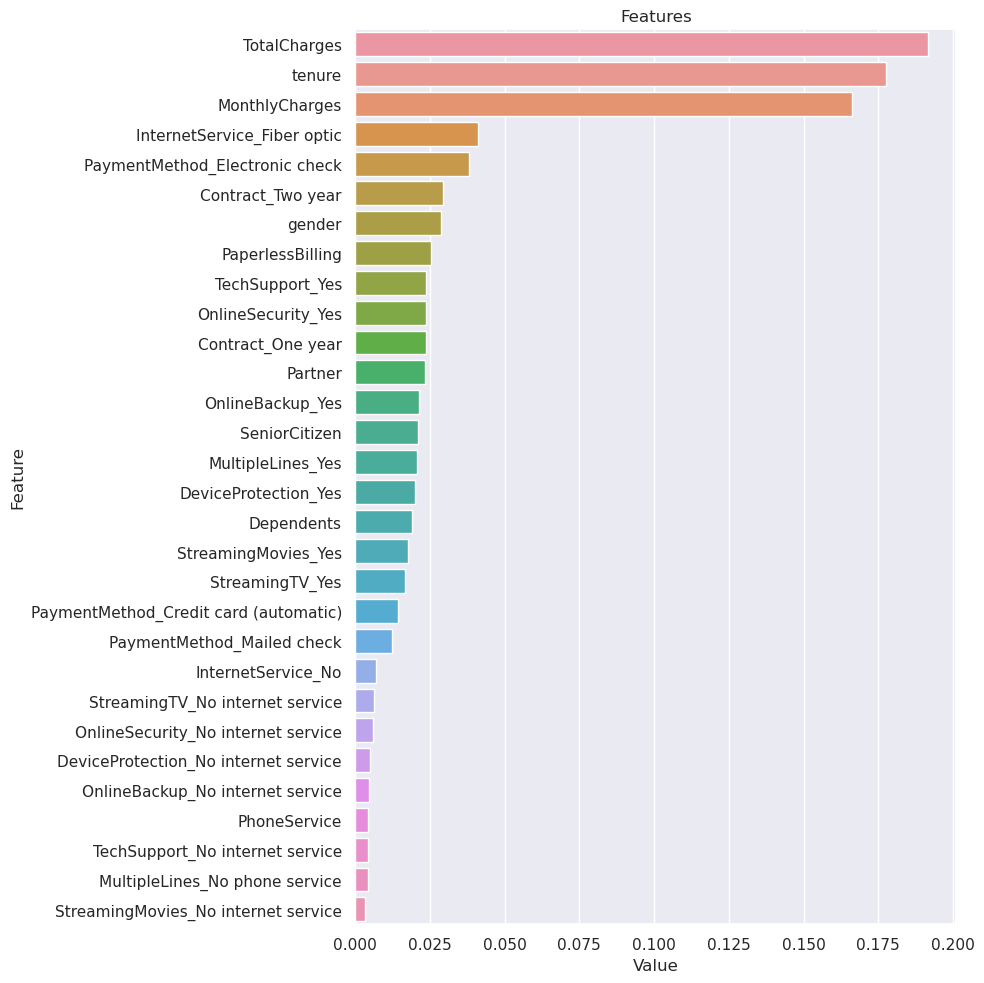

In [30]:
plot_importance(model=model_rf,features=X_train)